경로 확인: C:\Users\sangh\OneDrive\바탕 화면\AI\Ecommerce-Data-Analysis-Practice\data
데이터 로드 및 통합 시작...
Reading Sale_Change...
Reading Jeonse_Change...
Reading Sale_Index...
Reading Jeonse_Index...
Reading Scale_Sale...
Reading Scale_Jeonse...
Reading Age_Sale...
Reading Age_Jeonse...
통합 완료! 총 데이터 행 수: 4,109,364



17:41:35 - cmdstanpy - INFO - Chain [1] start processing



[관악] 분석 시작...

=== 관악 매매(Sale) 변동률 예측 ===


17:41:35 - cmdstanpy - INFO - Chain [1] done processing


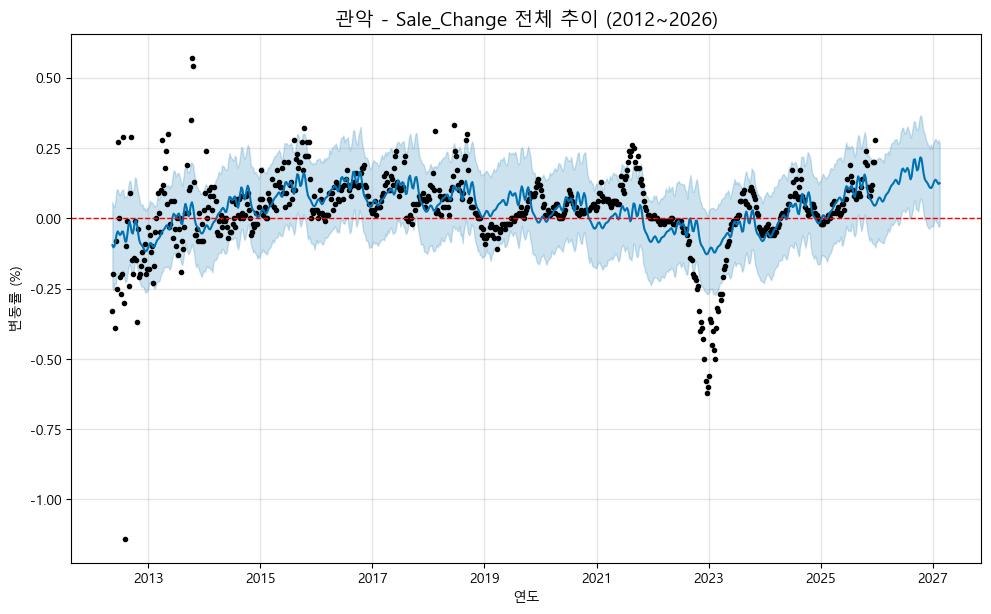

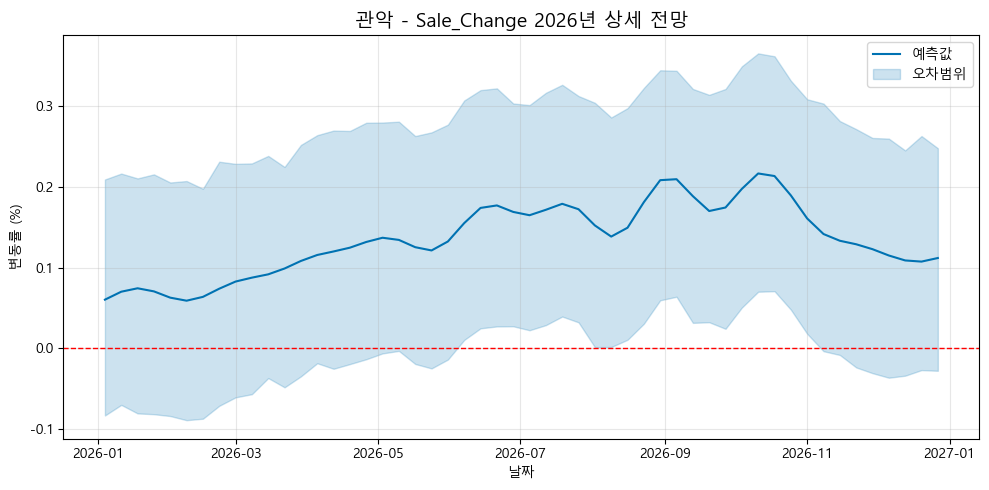

17:41:35 - cmdstanpy - INFO - Chain [1] start processing


2026년 평균 예상: 0.135% (상승장 🔥)
            날짜  예측변동률(%)       하한가       상한가
709 2026-01-04  0.060104 -0.083646  0.209240
710 2026-01-11  0.069985 -0.070459  0.216570
711 2026-01-18  0.074238 -0.081039  0.210589
712 2026-01-25  0.070396 -0.082026  0.215585
713 2026-02-01  0.062596 -0.084304  0.205507
714 2026-02-08  0.058826 -0.089452  0.207319
715 2026-02-15  0.063574 -0.087624  0.197725
716 2026-02-22  0.073721 -0.071627  0.231290
717 2026-03-01  0.082582 -0.061116  0.228634
718 2026-03-08  0.087430 -0.057166  0.229180

=== 관악 전세(Jeonse) 변동률 예측 ===


17:41:36 - cmdstanpy - INFO - Chain [1] done processing


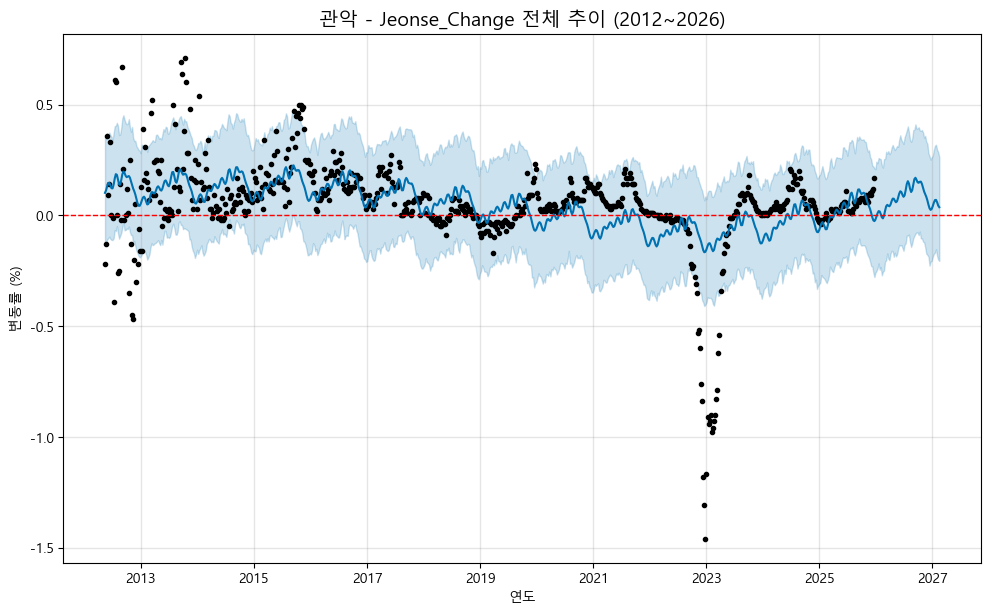

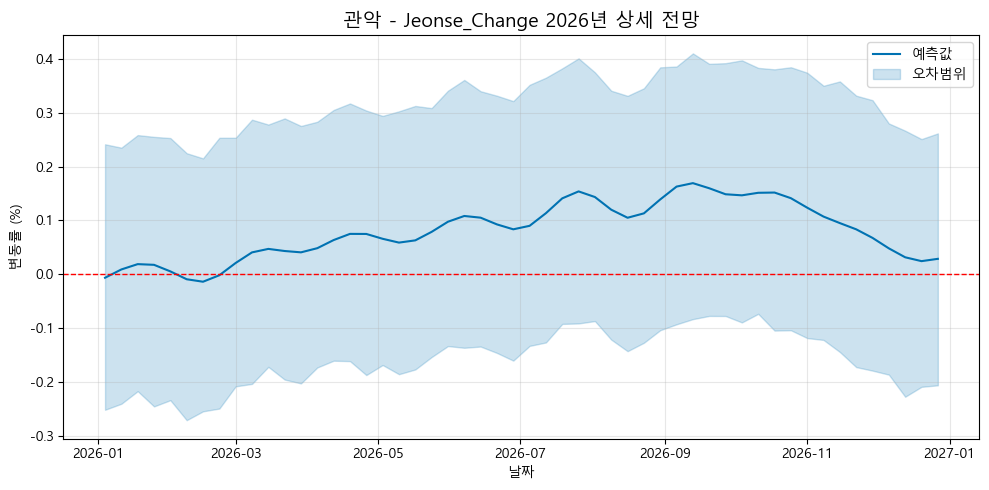

2026년 평균 예상: 0.081% (상승장 🔥)
            날짜  예측변동률(%)       하한가       상한가
709 2026-01-04 -0.006459 -0.251907  0.241660
710 2026-01-11  0.008979 -0.240707  0.235367
711 2026-01-18  0.018851 -0.217318  0.258741
712 2026-01-25  0.017569 -0.245667  0.255462
713 2026-02-01  0.005376 -0.234069  0.253257
714 2026-02-08 -0.009245 -0.271264  0.225070
715 2026-02-15 -0.013854 -0.254796  0.215507
716 2026-02-22 -0.001830 -0.249644  0.253738
717 2026-03-01  0.021031 -0.208342  0.253803
718 2026-03-08  0.040697 -0.203797  0.287409


[ㅂ] 분석 시작...
'ㅂ'에 대한 데이터가 없습니다.

프로그램을 종료합니다.


In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

BASE_PATH = r"C:\Users\sangh\OneDrive\바탕 화면\AI\Ecommerce-Data-Analysis-Practice\data"

FILE_LIST = {
    'Sale_Change': ("'25.12월 4주 주간아파트가격동향조사 시계열_매매변동률.csv", False),
    'Jeonse_Change': ("'25.12월 4주 주간아파트가격동향조사 시계열_전세변동률.csv", False),
    'Sale_Index': ("'25.12월 4주 주간아파트가격동향조사 시계열_매매지수.csv", False),
    'Jeonse_Index': ("'25.12월 4주 주간아파트가격동향조사 시계열_전세지수.csv", False),
    'Scale_Sale': ("'25.12월 4주 주간아파트가격동향조사 시계열_규모별매매변동률.csv", True),
    'Scale_Jeonse': ("'25.12월 4주 주간아파트가격동향조사 시계열_규모별전세변동률.csv", True),
    'Age_Sale': ("'25.12월 4주 주간아파트가격동향조사 시계열_연령별매매변동률.csv", True),
    'Age_Jeonse': ("'25.12월 4주 주간아파트가격동향조사 시계열_연령별전세변동률.csv", True),
}

def parse_custom_date(date_series):
    dates = []
    current_year = 2012
    last_month = 5

    for item in date_series:
        if pd.isna(item):
            dates.append(pd.NaT)
            continue
        
        item = str(item).strip().replace("'", "")

        if item.count('.') == 2:
            try:
                parts = item.split('.')
                y, m, d = int(parts[0]), int(parts[1]), int(parts[2])
                current_year = 2000 + y
                last_month = m
                dates.append(pd.Timestamp(year=current_year, month=m, day=d))
            except:
                dates.append(pd.NaT)
            continue

        try:
            parts = item.split('.')
            m, d = int(parts[0]), int(parts[1])
            if m < last_month:
                current_year += 1
            last_month = m
            dates.append(pd.Timestamp(year=current_year, month=m, day=d))
        except:
            dates.append(pd.NaT)
            
    return dates

def load_and_melt(filename, value_name, is_category=False):
    file_path = os.path.join(BASE_PATH, filename)
    
    if not os.path.exists(file_path):
        print(f"파일을 찾을 수 없음: {filename}")
        return pd.DataFrame()
    
    try:
        nrows = 4 if is_category else 3
        try:
            df_header = pd.read_csv(file_path, encoding='cp949', header=None, nrows=nrows)
        except:
            df_header = pd.read_csv(file_path, encoding='utf-8', header=None, nrows=nrows)
        
        if is_category:
            row_region = df_header.iloc[1]
            row_sub = df_header.iloc[3]
        else:
            row_region = df_header.iloc[1]
            row_sub = df_header.iloc[2]
        
        cols = []
        current_region = None
        
        for i in range(len(row_region)):
            r1 = row_region[i]
            sub = row_sub[i]

            if pd.notna(r1):
                clean_region = str(r1).replace('\n', '').split('(')[0].strip()
                current_region = clean_region

            if pd.notna(sub):
                clean_sub = str(sub).replace('\n', '').strip()
                if current_region:
                    if clean_sub == current_region:
                        col_name = current_region
                    else:
                        col_name = f"{current_region}_{clean_sub}"
                else:
                    col_name = clean_sub
            else:
                col_name = current_region if current_region else f"Unknown_{i}"
            cols.append(col_name)

        try:
            df = pd.read_csv(file_path, encoding='cp949', header=None, skiprows=5)
        except:
            df = pd.read_csv(file_path, encoding='utf-8', header=None, skiprows=5)

        len_header = len(cols)
        len_data = len(df.columns)
        min_len = min(len_header, len_data)
        
        df = df.iloc[:, :min_len]
        cols = cols[:min_len]
        
        df.columns = cols
        
        df.rename(columns={df.columns[0]: 'Date_Raw'}, inplace=True)
        df['Date'] = parse_custom_date(df['Date_Raw'])
        df = df.drop(columns=['Date_Raw'])

        df_melted = df.melt(id_vars=['Date'], var_name='Region', value_name=value_name)
        return df_melted.dropna(subset=['Date'])
    
    except Exception as e:
        print(f"처리 중 오류: {filename} - {e}")
        return pd.DataFrame()

print(f"경로 확인: {BASE_PATH}")
print("데이터 로드 및 통합 시작...")

master_df = None

for col_name, (filename, is_cat) in FILE_LIST.items():
    print(f"Reading {col_name}...")
    temp_df = load_and_melt(filename, col_name, is_category=is_cat)
    if not temp_df.empty:
        if master_df is None:
            master_df = temp_df
        else:
            master_df = pd.merge(master_df, temp_df, on=['Date', 'Region'], how='outer')

if master_df is not None:
    master_df = master_df.sort_values(['Region', 'Date']).reset_index(drop=True)
    print(f"통합 완료! 총 데이터 행 수: {len(master_df):,}")
else:
    print("데이터를 불러오지 못했습니다.")
    exit()

def run_prophet_model(df, target_col, region_name):
    prophet_df = df[['Date', target_col]].dropna().rename(columns={'Date': 'ds', target_col: 'y'})
    
    if len(prophet_df) < 30:
        print(f"데이터 부족으로 {target_col} 예측 불가")
        return None

    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=60, freq='W')
    forecast = model.predict(future)

    forecast_2026 = forecast[forecast['ds'].dt.year == 2026][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_2026.columns = ['날짜', '예측변동률(%)', '하한가', '상한가']

    model.plot(forecast)
    plt.title(f"{region_name} - {target_col} 전체 추이 (2012~2026)", fontsize=14)
    plt.xlabel("연도")
    plt.ylabel("변동률 (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(forecast_2026['날짜'], forecast_2026['예측변동률(%)'], label='예측값', color='#0072B2')
    plt.fill_between(forecast_2026['날짜'], 
                     forecast_2026['하한가'], 
                     forecast_2026['상한가'], 
                     color='#0072B2', alpha=0.2, label='오차범위')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"{region_name} - {target_col} 2026년 상세 전망", fontsize=14)
    plt.xlabel("날짜")
    plt.ylabel("변동률 (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return forecast_2026

def predict_real_estate(target_region):
    print(f"\n[{target_region}] 분석 시작...")
    
    region_mask = master_df['Region'] == target_region
    if not region_mask.any():
        similar = [r for r in master_df['Region'].unique() if target_region in str(r)]
        if similar:
            print(f"'{target_region}' 데이터를 찾을 수 없습니다.")
            print(f"추천 검색어: {similar[:5]}")
        else:
            print(f"'{target_region}'에 대한 데이터가 없습니다.")
        return
            
    df_subset = master_df[region_mask].copy()

    print(f"\n=== {target_region} 매매(Sale) 변동률 예측 ===")
    sale_result = run_prophet_model(df_subset, 'Sale_Change', target_region)
    if sale_result is not None:
        avg = sale_result['예측변동률(%)'].mean()
        status = "상승장 🔥" if avg > 0 else "하락/조정장 ❄️"
        print(f"2026년 평균 예상: {avg:.3f}% ({status})")
        print(sale_result.head(10))

    print(f"\n=== {target_region} 전세(Jeonse) 변동률 예측 ===")
    jeonse_result = run_prophet_model(df_subset, 'Jeonse_Change', target_region)
    if jeonse_result is not None:
        avg = jeonse_result['예측변동률(%)'].mean()
        status = "상승장 🔥" if avg > 0 else "하락/조정장 ❄️"
        print(f"2026년 평균 예상: {avg:.3f}% ({status})")
        print(jeonse_result.head(10))

while True:
    print("\n" + "="*40)
    user_input = input("검색할 지역명을 입력하세요 (종료하려면 'q' 입력): ")
    
    if user_input.lower() == 'q':
        print("프로그램을 종료합니다.")
        break
        
    predict_real_estate(user_input)